TODO list:

- test communication with all servos at once
- separate power supply for servos
- mount secure brace onto servos
- mount servos onto wood or something
- plot angles/samples

In [1]:
from __future__ import division

import serial
import numpy as np
from collections import defaultdict
import Queue
import time
import threading
import matplotlib.pyplot as plt
%matplotlib inline

from rtlsdr import RtlSdr, librtlsdr, helpers

In [2]:
# function to compute average power spectrum
def avgPS( x, N=256, fs=1):
    M = np.floor(len(x)/N)
    x_ = np.reshape(x[:M*N],(M,N)) * np.hamming(N)[None,:]
    X = np.fft.fftshift(np.fft.fft(x_,axis=1),axes=1)
    return np.r_[-N/2.0:N/2.0]/N*fs, np.mean(abs(X**2),axis=0)

def maxPower(x, N=256, fs=1, M=None):
    M = np.floor(len(x)/N)
    x_ = np.reshape(x[:M*N],(M,N)) * np.hamming(N)[None,:]
    X = np.fft.fftshift(np.fft.fft(x_,axis=1),axes=1)
    return abs(X**2).T.max(axis=0)

def smoothMaxPower(mp, fs):
    M = int(fs/5e3) # 5000
    if M % 2 == 0:
        M -= 1
    w = np.hanning(M)
    mp_smooth = np.convolve(np.hstack((mp[:M/2],mp,mp[-M/2:])), w/w.sum(), 'valid')
    assert(len(mp) == len(mp_smooth))
    return mp_smooth

# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60) :
    eps = 1e-3
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( abs( y ) / y_max + eps )
    
    fig=plt.figure(figsize=(15,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()


def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    isreal_bool = np.isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = np.append(x,np.zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = np.concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[np.r_[m//2:len(x),np.ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * np.hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print 1
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

In [3]:
class Servos:
    """
    Commands servos via serial port
    """
    
    def __init__(self, num_servos, port, baudrate=115200):
        self.num_servos = num_servos
        self.serial = serial.Serial(port, baudrate=baudrate, timeout=1.)
        #self.set_speeds([0]*self.num_servos)
        
        self.read_queues = [Queue.Queue() for _ in xrange(self.num_servos)]
        self.read_stop = False
        self.read_serial_thread = threading.Thread(target=self.read_serial_run, args=())
        self.read_serial_thread.daemon = True
        self.read_serial_thread.start()
    
    def set_speed(self, ith, speed):
        s = '{0}{1:.3f}\n'.format(ith, speed)
        for char in s:
            self.serial.write(char)
            time.sleep(0.001)
        
    def set_speeds(self, speeds):
        assert(len(speeds) == self.num_servos)
        for ith in xrange(self.num_servos):
            self.set_speed(ith, speeds[ith])
    
    def read_serial_run(self):
        while not self.read_stop:
            #print('read_serial_run: waiting for readline...')
            #line = self.read_line()
            try:
                line = self.serial.readline()
            except Exception:
                time.sleep(0.001)
                continue
            if len(line) == 0:
                continue
            servo_num, angle, t = line.split('_')

            servo_num = int(servo_num)
            angle = float(angle)
            t = float(t)

            #print('servo_num: {0}'.format(servo_num))
            #print('angle: {0}'.format(angle))
            #print('t: {0}\n'.format(t))
            self.read_queues[servo_num].put((angle, t))
            
    def get_limitangle_and_time(self, ith):
        return self.read_queues[ith].get()
    
if 'servos' in locals():
    servos.read_stop = True
    time.sleep(0.1)
servos = Servos(3, '/dev/ttyACM0')

In [4]:
#####################
# Test ServosSerial #
#####################

speed = 1.0
ith = 0

#t0 = time.time()
servos.set_speed(ith, speed)
#time.sleep(5)
a0, t0 = servos.get_limitangle_and_time(ith)
a1, t1 = servos.get_limitangle_and_time(ith)
servos.set_speed(ith, 0)
#t1 = time.time()

print('[a0, a1]: [{0}, {1}]'.format(a0, a1))
print('Elapsed: {0}'.format(t1 - t0))

[a0, a1]: [-1.047, 1.047]
Elapsed: 2.101


In [3]:
class SDRs:
    """
    Functionality for multiple SDRs (non-blocking)
    """
    def __init__(self, rtlsdr_devs, fc, fs=2.4e6, gain=1.0):
        self.rtlsdr_devs = rtlsdr_devs
        self.rtlsdrs = [None]*len(self.rtlsdr_devs)
        
        self.fc = fc
        self.fs = fs
        self.gain = gain
            
        # for asynchronous reads
        self.read_queues = [Queue.Queue() for _ in self.rtlsdr_devs]
        self.read_run_flags = [False]*len(self.rtlsdr_devs)
        self.read_is_stoppeds = [False]*len(self.rtlsdr_devs)
        self.read_threads = [None]*len(self.rtlsdr_devs)
        
        for ith, rtlsdr_dev in enumerate(self.rtlsdr_devs):
            if rtlsdr_dev is None:
                continue
            
            self.rtlsdrs[ith] = RtlSdr(rtlsdr_dev)
            self.rtlsdrs[ith].sample_rate = self.fs
            self.rtlsdrs[ith].center_freq = self.fc
            self.rtlsdrs[ith].gain = self.gain

            self.read_threads[ith] = threading.Thread(target=self.run, args=(ith,))
            self.read_threads[ith].daemon = True
            self.read_threads[ith].start()
            
    def set_gains(self, gain):
        self.gain = gain
        for rtlsdr in self.rtlsdrs:
            if rtlsdr is not None:
                rtlsdr.gain = self.gain
    
    def start_read(self, ith):
        if self.read_run_flags[ith] or \
            self.rtlsdr_devs[ith] is None or \
            self.read_is_stoppeds[ith]:
            return False
        
        self.read_run_flags[ith] = True
        return True
        
    def stop_read(self, ith):
        """ Returns maxPower of samples gathered """
        if not self.read_run_flags[ith] or self.rtlsdr_devs[ith] is None:
            return None
        
        self.read_run_flags[ith] = False
        
        x = np.array([])
        while not self.read_queues[ith].empty():
            x = np.append(x, self.read_queues[ith].get())
        return np.array(x)
    
    def run(self, ith, M=8*1024):
        def read_cb(samples, q):
            if self.read_run_flags[ith]:
                try:
                    q.put(maxPower(samples))
                except Exception as e:
                    print('read_cb exception: {0}'.format(e))
            
        try:
            self.rtlsdrs[ith].read_samples_async(read_cb, M, context=self.read_queues[ith])
        except Exception as e:
            print(e)
        self.read_is_stoppeds[ith] = True
    
num_sdrs = 3
fc = 145.6e6

dev_cnt = librtlsdr.rtlsdr_get_device_count()
rtlsdr_devs = [i if i < dev_cnt else None for i in xrange(num_sdrs)]
sdrs = SDRs(rtlsdr_devs, fc)

In [9]:
#############
# Test SDRs #
#############
print('Start reading')
sdrs.start_read(0)
print('Sleeping...')
time.sleep(1)
print('Stop reading')
x = np.array([])
start = time.time()
x = sdrs.stop_read(0)
print('len(x): {0}'.format(len(x)))
print('time to stop: {0}'.format(time.time() - start))

Start reading
Sleeping...
Stop reading
len(x): 9440
time to stop: 0.0142338275909


In [5]:
class ServosSDRs:
    """
    Command servos and read from SDRs
    """
    def __init__(self, servos, sdrs):
        self.servos = servos
        self.sdrs = sdrs
        
        self.default_speed = np.pi/3.
        
        self.run_flags = [False]*self.servos.num_servos
        self.is_stoppeds = [False]*self.servos.num_servos
        self.threads = [None]*self.servos.num_servos
        
        self.angles_and_maxpowers = [Queue.Queue() for _ in xrange(self.servos.num_servos)]
        
    def start(self, ith, speed=None, run_on_stop_read=lambda:None):
        if self.run_flags[ith]:
            return
        
        for q in self.angles_and_maxpowers:
            with q.mutex:
                q.queue.clear()
        
        self.run_flags[ith] = True
        self.threads[ith] = threading.Thread(target=self.run, args=(ith,speed,run_on_stop_read,))
        self.threads[ith].daemon = True
        self.threads[ith].start()                 
    
    def stop(self, ith):
        if not self.run_flags[ith]:
            return
        
        self.run_flags[ith] = False
        
        while not self.is_stoppeds[ith]:
            time.sleep(0.2)
        self.is_stoppeds[ith] = False
        
    def run(self, ith, speed=None, run_on_stop_read=lambda:None):
        """ run_on_stop_read for things like plotting """
        speed = self.default_speed if speed is None else speed
        num_exceptions = 0
        self.servos.set_speed(ith, speed)
        
        last_limitangle, last_t = None, None
        while self.run_flags[ith]:
            try:
                self.sdrs.start_read(ith)
                limitangle, t = self.servos.get_limitangle_and_time(ith)
                mp = self.sdrs.stop_read(ith)
                
                if mp is not None and last_limitangle is not None and last_t is not None:
                    angles = np.linspace(last_limitangle, limitangle, len(mp))
                    self.angles_and_maxpowers[ith].put([angles, mp])
                
                last_limitangle, last_t = limitangle, t
                run_on_stop_read()
            except Exception as e:
                num_exceptions += 1
                print('ServosSdr.run exception: {0}'.format(e))
                
                if num_exceptions > 1:
                    break
            
        self.servos.set_speed(ith, 0)
        self.is_stoppeds[ith] = True
        
    def get_angles_and_maxpowers(self, ith):
        """ For ith sdr, return oldest angle/sample if exists, else None """
        if not self.angles_and_maxpowers[ith].empty():
            return self.angles_and_maxpowers[ith].get()
            
servos_sdrs = ServosSDRs(servos, sdrs)

In [41]:
###################
# Test ServosSDRs #
###################

sdrs.set_gains(1.)

ham = serial.Serial('/dev/ttyUSB0')
ham.setDTR(1)
time.sleep(0.5)

ith = 0
servos_sdrs.start(ith, speed=np.pi/3.)
print('Press enter to stop')

raw_input()
servos_sdrs.stop(ith)       

ham.setDTR(0)

angles_and_maxpowers0 = list()
a_and_mp = servos_sdrs.get_angles_and_maxpowers(0)
while a_and_mp is not None:
    angles_and_maxpowers0.append(a_and_mp)
    a_and_mp = servos_sdrs.get_angles_and_maxpowers(0)
print('rotations: {0}'.format(len(angles_and_maxpowers0)))

Press enter to stop

rotations: 3


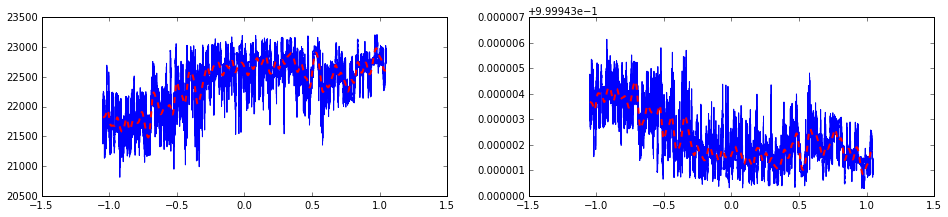

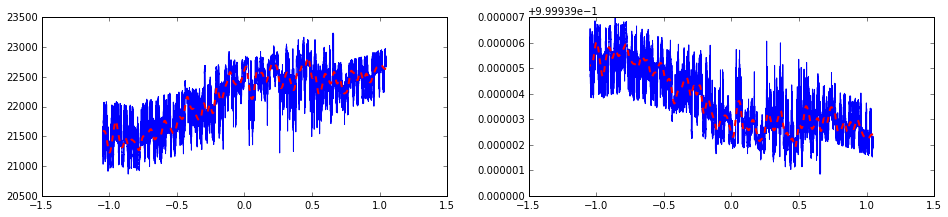

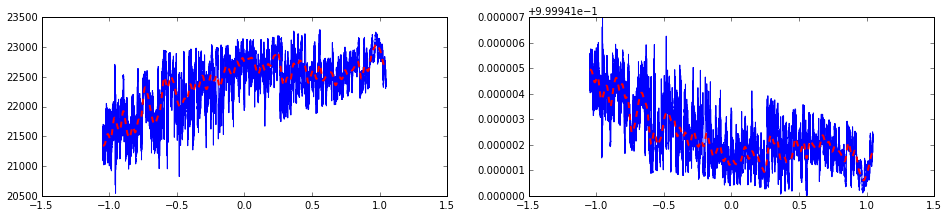

In [42]:
for angles, mp in angles_and_maxpowers0:
    mp_smooth = smoothMaxPower(mp, sdrs.fs)
    #angles = np.linspace(angles[0], angles[-1], len(mp))
    angles = angles[::-1]
    
    width, height = plt.figaspect(0.2)
    f, axes = plt.subplots(1,2, figsize=(width,height))
    axes[0].plot(angles, mp)
    axes[0].plot(angles, mp_smooth, 'r--', linewidth=2.0)
    axes[1].plot(angles, 1 - mp/mp.sum())
    axes[1].plot(angles, 1 - mp_smooth/mp_smooth.sum(), 'r--', linewidth=2.0)
    #plt.ylim((mp.mean()-3*mp.std(), mp.mean()+3*mp.std()))

In [4]:
#####################################
# Test shielding makes a difference #
#####################################

ham = serial.Serial('/dev/ttyUSB1')
ham.setDTR(1)
time.sleep(0.2)

"""
fs = 2.4e5
fc = 145.6e6 
if 'sdr' not in locals():
    sdr = RtlSdr()
sdr.sample_rate = fs
sdr.center_freq = fc
sdr.gain = 0.1 # 20 without antenna, 0.1 with

start = time.time()
N_samples = 2.56e5*3 # approximately seconds
data = sdr.read_samples(N_samples)
print('Elapsed: {0}'.format(time.time() - start))
"""

sdrs.set_gains(1.)
sdrs.start_read(0)
time.sleep(4)
data = sdrs.stop_read(0)

ham.setDTR(0)

In [ ]:
trim = 0
mp = data[trim:]
mp_smooth = smoothMaxPower(mp, 5*sdrs.fs)

f = plt.figure()
plt.plot(mp, 'b-')
plt.plot(mp_smooth, 'r-', linewidth=2)

f = plt.figure()
D = np.fft.fft(data)
freq = sdrs.fs * np.fft.fftfreq(D.shape[-1])
b = abs(freq) < 1000
plt.plot(freq[b], abs(D)[b], 'x')